# Modeling
in previous notebook we investigated the linear algorithms for regression problem which we discussed previously. in this notebook we are going to discuss non-linear approaches for regression problem. the non-linear algorithms which we will check in this notebook are:
- k-nearest neighbor
- decision tree
- random forest

and in the next notebooks we will discuss classification and clustering algorithms.

the reason behind the dividing the notebooks is making the understanding of principles more easily.

an imortant fact to have in mind in contrast of plotting the trained model is that in order to minimizing the effect of simpson's paradox on dataset, for plotting we are training a single variable regression based on the algorithm and then plotting it. the final model will be multivariate.

----

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
import matplotlib
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 200)
import seaborn as sns
from openpyxl import load_workbook
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from tqdm import tqdm_notebook, tqdm

In [2]:
xls = pd.ExcelFile('data/Main Dataset V3.0 .xlsx')
ad_post = pd.read_excel(xls, 'Ad-Post')
ad_story = pd.read_excel(xls, 'Ad-Story')
influencer = pd.read_excel(xls, 'Influencer')
leaders_post = pd.read_excel(xls, 'Leaders-Post')
leaders_story = pd.read_excel(xls, 'Leaders-Story')
post = pd.read_excel(xls, 'Post')
story = pd.read_excel(xls, 'Story')
print('Datasets Loaded Completely.')

Datasets Loaded Completely.


In [3]:
#dummying dataset

# advertising posts
dummy_field = pd.get_dummies(ad_post['field'], prefix='field')
ad_post_dummy = pd.concat([ad_post, dummy_field], axis=1)
ad_post_dummy.drop(['field'], axis=1, inplace=True)

# advertising stories
dummy_field = pd.get_dummies(ad_story['field'], prefix='field')
ad_story_dummy = pd.concat([ad_story, dummy_field], axis=1)
ad_story_dummy.drop(['field'], axis=1, inplace=True)

#influencer
dummy_gender = pd.get_dummies(influencer['gender'], prefix='gender')
dummy_field = pd.get_dummies(influencer['field'], prefix='field')
influencer_dummy = pd.concat([influencer, dummy_gender, dummy_field], axis=1)
influencer_dummy.drop(['gender', 'field'], axis=1, inplace=True)

#leaders posts
dummy_gender = pd.get_dummies(leaders_post['gender'], prefix='gender')
leaders_post_dummy = pd.concat([leaders_post, dummy_gender], axis=1)
leaders_post_dummy.drop(['gender'], axis=1, inplace=True)

In [4]:
# label encoding dataset

# advertising posts
labels, _ = pd.factorize(ad_post['field'])
ad_post_labelencoded = ad_post
ad_post_labelencoded['field_labelencoded'] = labels.tolist()

# advertising stories
labels, _ = pd.factorize(ad_story['field'])
ad_story_labelencoded = ad_story
ad_story_labelencoded['field_labelencoded'] = labels.tolist()

# influencer
labels, _ = pd.factorize(influencer['gender'])
influencer_labelencoded = influencer
influencer_labelencoded['gender_labelencoded'] = labels.tolist()
labels, _ = pd.factorize(influencer['field'])
influencer_labelencoded['field_labelencoded'] = labels.tolist()

# leaders post
labels, _ = pd.factorize(leaders_post['gender'])
leaders_post_labelencoded = leaders_post
leaders_post_labelencoded['gender_labelencoded'] = labels.tolist()

In [5]:
ad_post_y = np.asarray(ad_post_dummy[['cost']])
ad_post_x = np.asarray(ad_post_dummy[['follower', 'view', 'field_art & culture', 'field_fact', 'field_video', 'field_women']])


ad_story_y = np.asarray(ad_story_dummy[['cost']])
ad_story_x = np.asarray(ad_story_dummy[['view', 'follower', 'action', 'interaction', 'impression', 'field_art & culture', 'field_fact', 'field_health',
                                       'field_news', 'field_video', 'field_women']])

influencer_y = np.asarray(influencer_dummy[['cost']])
influencer_x = np.asarray(influencer_dummy[['follower', 'view', 'action', 'impression', 'cta', 'interaction', 'gender_family', 'gender_female', 'gender_male',
                                           'field_cooking', 'field_health', 'field_lifestyle', 'field_sport', 'field_tourism']])

leaders_post_y = np.asarray(leaders_post_dummy[['cost']])
leaders_post_x = np.asarray(leaders_post_dummy[['follower', 'view', 'like', 'comment', 'share', 'save', 'profile_visit', 'reach', 'impression', 'gender_family',
                                               'gender_female', 'gender_male']])

### K-Nearest Neighbor Regressor

#### Advertising Posts

In [6]:
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

In [7]:
weights = ['uniform', 'distance']

In [8]:
temp_lst = []
neighbors = np.arange(2, 10)
for i in tqdm_notebook(range(2, 9)):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(ad_post_x):
        X_train, X_test = ad_post_x[train_index], ad_post_x[test_index]
        y_train, y_test = ad_post_y[train_index], ad_post_y[test_index]
        for n in np.arange(2, 9):
            for w in weights:
                knr = KNeighborsRegressor(n_neighbors = n, weights = w)
                knr.fit(X_train, y_train)
                temp_lst2 = []
                temp_lst2.append(i)
                temp_lst2.append(n)
                temp_lst2.append(w)
                temp_lst2.append(knr.score(X_train, y_train))
                temp_lst2.append(knr.score(X_test, y_test))
                temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst, columns=['k', '# of Neighbors', 'Weights', 'KNR Train Score', 'KNR Test Score'])

temp_lst = []
for k in range(2, 9):
    for n_ in np.arange(2, 9):
        for w_ in weights:
            temp_lst2 = []
            temp_lst2.append(k)
            temp_lst2.append(n_)
            temp_lst2.append(w_)
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['# of Neighbors'] == n_) & 
                                                      (temp_df['Weights'] == w_)]['KNR Train Score']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['# of Neighbors'] == n_) & 
                                                      (temp_df['Weights'] == w_)]['KNR Test Score']), decimals=4))
            temp_lst.append(temp_lst2)

nn_reg_eval_df = pd.DataFrame(temp_lst, columns=['k', '# of Neighbors', 'Weights', 'KNR Train Score', 'KNR Test Score'])
nn_reg_eval_df

,k,# of Neighbors,Weights,KNR Train Score,KNR Test Score
0,2,2,uniform,0.75,0.09
1,2,2,distance,1.00,0.02
2,2,3,uniform,0.57,0.18
3,2,3,distance,1.00,0.12
4,2,4,uniform,0.51,0.19
5,2,4,distance,1.00,0.16
6,2,5,uniform,0.48,0.22
7,2,5,distance,1.00,0.20
8,2,6,uniform,0.43,0.20
9,2,6,distance,1.00,0.20


In [9]:
nn_reg_eval_df.nlargest(3, 'KNR Test Score')

,k,# of Neighbors,Weights,KNR Train Score,KNR Test Score
56,6,2,uniform,0.88,0.44
57,6,2,distance,1.00,0.43
15,3,2,distance,1.00,0.37


In [10]:
nn_reg_eval_df.nsmallest(3, 'KNR Test Score')

,k,# of Neighbors,Weights,KNR Train Score,KNR Test Score
86,8,3,uniform,0.78,-0.65
96,8,8,uniform,0.50,-0.46
87,8,3,distance,1.00,-0.41


as you can see in the table above this approach didn't perform very well on advertising posts dataset. it's good to check its fitted model on dataset.

In [11]:
knr_uniform = KNeighborsRegressor(n_neighbors=3, weights='uniform')
knr_distance = KNeighborsRegressor(n_neighbors=3, weights='distance')
knr_uniform = knr_uniform.fit(ad_post_x, ad_post_y)
knr_distance = knr_distance.fit(ad_post_x, ad_post_y)

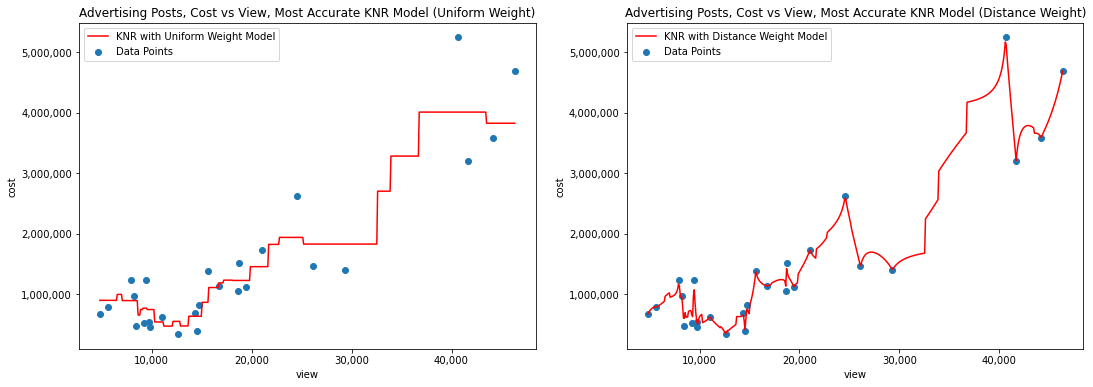

In [12]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(ad_post_dummy['view'], ad_post_dummy['cost'], label='Data Points')
ax2.scatter(ad_post_dummy['view'], ad_post_dummy['cost'], label='Data Points')
X_plot = np.linspace(ad_post_dummy['view'].min(), ad_post_dummy['view'].max(), 500).reshape(-1, 1)
y_plot_uniform = knr_uniform.fit(ad_post_x[:, 1].reshape(-1, 1), ad_post_y).predict(X_plot)
y_plot_distance = knr_distance.fit(ad_post_x[:, 1].reshape(-1, 1), ad_post_y).predict(X_plot)
ax1.plot(X_plot, y_plot_uniform, '-r', label='KNR with Uniform Weight Model')
ax2.plot(X_plot, y_plot_distance, '-r', label='KNR with Distance Weight Model')
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.set_title(f'Advertising Posts, Cost vs View, Most Accurate KNR Model (Uniform Weight)')
ax1.set_xlabel('view')
ax1.set_ylabel('cost')
ax1.legend()
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_title(f'Advertising Posts, Cost vs View, Most Accurate KNR Model (Distance Weight)')
ax2.set_xlabel('view')
ax2.set_ylabel('cost')
ax2.legend()
plt.show()

#### Advertising Stories

In [13]:
temp_lst = []
neighbors = np.arange(2, 10)
for i in tqdm_notebook(range(2, 9)):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(ad_story_x):
        X_train, X_test = ad_story_x[train_index], ad_story_x[test_index]
        y_train, y_test = ad_story_y[train_index], ad_story_y[test_index]
        for n in np.arange(2, 9):
            for w in weights:
                knr = KNeighborsRegressor(n_neighbors = n, weights = w)
                knr.fit(X_train, y_train)
                temp_lst2 = []
                temp_lst2.append(i)
                temp_lst2.append(n)
                temp_lst2.append(w)
                temp_lst2.append(knr.score(X_train, y_train))
                temp_lst2.append(knr.score(X_test, y_test))
                temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst, columns=['k', '# of Neighbors', 'Weights', 'KNR Train Score', 'KNR Test Score'])

temp_lst = []
for k in range(2, 9):
    for n_ in np.arange(2, 9):
        for w_ in weights:
            temp_lst2 = []
            temp_lst2.append(k)
            temp_lst2.append(n_)
            temp_lst2.append(w_)
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['# of Neighbors'] == n_) & 
                                                      (temp_df['Weights'] == w_)]['KNR Train Score']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['# of Neighbors'] == n_) & 
                                                      (temp_df['Weights'] == w_)]['KNR Test Score']), decimals=4))
            temp_lst.append(temp_lst2)

nn_reg_eval_df = pd.DataFrame(temp_lst, columns=['k', '# of Neighbors', 'Weights', 'KNR Train Score', 'KNR Test Score'])
nn_reg_eval_df

,k,# of Neighbors,Weights,KNR Train Score,KNR Test Score
0,2,2,uniform,0.80,0.38
1,2,2,distance,1.00,0.44
2,2,3,uniform,0.57,0.33
3,2,3,distance,1.00,0.42
4,2,4,uniform,0.54,0.36
5,2,4,distance,1.00,0.43
6,2,5,uniform,0.43,0.33
7,2,5,distance,1.00,0.40
8,2,6,uniform,0.40,0.31
9,2,6,distance,1.00,0.39


In [14]:
nn_reg_eval_df.nlargest(3, 'KNR Test Score')

,k,# of Neighbors,Weights,KNR Train Score,KNR Test Score
1,2,2,distance,1.00,0.44
5,2,4,distance,1.00,0.43
3,2,3,distance,1.00,0.42


In [15]:
nn_reg_eval_df.nsmallest(3, 'KNR Test Score')

,k,# of Neighbors,Weights,KNR Train Score,KNR Test Score
85,8,2,distance,1.00,-12.33
84,8,2,uniform,0.88,-12.10
86,8,3,uniform,0.74,-10.53


In [16]:
knr_uniform = KNeighborsRegressor(n_neighbors=3, weights='uniform')
knr_distance = KNeighborsRegressor(n_neighbors=3, weights='distance')
knr_uniform = knr_uniform.fit(ad_story_x, ad_story_y)
knr_distance = knr_distance.fit(ad_story_x, ad_story_y)

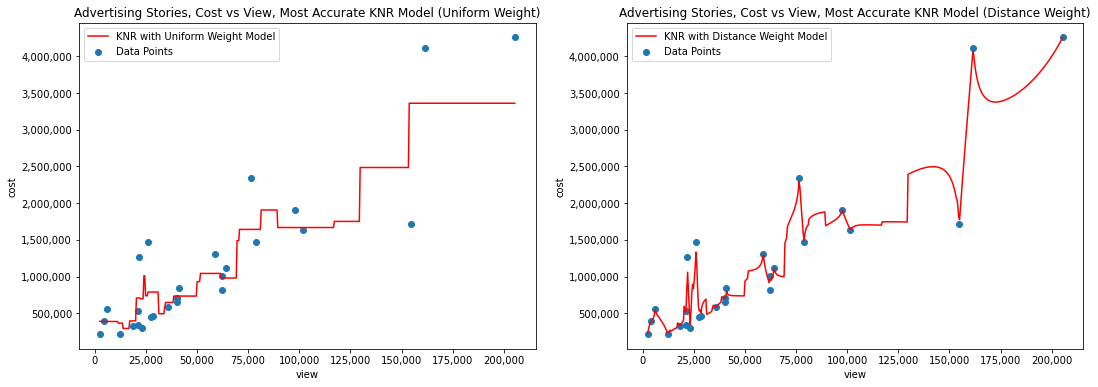

In [17]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(ad_story_dummy['view'], ad_story_dummy['cost'], label='Data Points')
ax2.scatter(ad_story_dummy['view'], ad_story_dummy['cost'], label='Data Points')
X_plot = np.linspace(ad_story_dummy['view'].min(), ad_story_dummy['view'].max(), 500).reshape(-1, 1)
y_plot_uniform = knr_uniform.fit(ad_story_x[:, 0].reshape(-1, 1), ad_story_y).predict(X_plot)
y_plot_distance = knr_distance.fit(ad_story_x[:, 0].reshape(-1, 1), ad_story_y).predict(X_plot)
ax1.plot(X_plot, y_plot_uniform, '-r', label='KNR with Uniform Weight Model')
ax2.plot(X_plot, y_plot_distance, '-r', label='KNR with Distance Weight Model')
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.set_title(f'Advertising Stories, Cost vs View, Most Accurate KNR Model (Uniform Weight)')
ax1.set_xlabel('view')
ax1.set_ylabel('cost')
ax1.legend()
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_title(f'Advertising Stories, Cost vs View, Most Accurate KNR Model (Distance Weight)')
ax2.set_xlabel('view')
ax2.set_ylabel('cost')
ax2.legend()
plt.show()

#### Influencers

In [18]:
temp_lst = []
neighbors = np.arange(2, 10)
for i in tqdm_notebook(range(2, 9)):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(influencer_x):
        X_train, X_test = influencer_x[train_index], influencer_x[test_index]
        y_train, y_test = influencer_y[train_index], influencer_y[test_index]
        for n in np.arange(2, 9):
            for w in weights:
                knr = KNeighborsRegressor(n_neighbors = n, weights = w)
                knr.fit(X_train, y_train)
                temp_lst2 = []
                temp_lst2.append(i)
                temp_lst2.append(n)
                temp_lst2.append(w)
                temp_lst2.append(knr.score(X_train, y_train))
                temp_lst2.append(knr.score(X_test, y_test))
                temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst, columns=['k', '# of Neighbors', 'Weights', 'KNR Train Score', 'KNR Test Score'])

temp_lst = []
for k in range(2, 9):
    for n_ in np.arange(2, 9):
        for w_ in weights:
            temp_lst2 = []
            temp_lst2.append(k)
            temp_lst2.append(n_)
            temp_lst2.append(w_)
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['# of Neighbors'] == n_) & 
                                                      (temp_df['Weights'] == w_)]['KNR Train Score']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['# of Neighbors'] == n_) & 
                                                      (temp_df['Weights'] == w_)]['KNR Test Score']), decimals=4))
            temp_lst.append(temp_lst2)

nn_reg_eval_df = pd.DataFrame(temp_lst, columns=['k', '# of Neighbors', 'Weights', 'KNR Train Score', 'KNR Test Score'])
nn_reg_eval_df

,k,# of Neighbors,Weights,KNR Train Score,KNR Test Score
0,2,2,uniform,1.00,0.09
1,2,2,distance,1.00,0.09
2,2,3,uniform,1.00,0.09
3,2,3,distance,1.00,0.09
4,2,4,uniform,1.00,0.31
5,2,4,distance,1.00,0.29
6,2,5,uniform,0.97,0.42
7,2,5,distance,1.00,0.39
8,2,6,uniform,0.92,0.39
9,2,6,distance,1.00,0.38


In [19]:
nn_reg_eval_df.nlargest(3, 'KNR Test Score')

,k,# of Neighbors,Weights,KNR Train Score,KNR Test Score
37,4,6,distance,1.00,0.65
39,4,7,distance,1.00,0.64
36,4,6,uniform,0.96,0.63


In [20]:
nn_reg_eval_df.nsmallest(3, 'KNR Test Score')

,k,# of Neighbors,Weights,KNR Train Score,KNR Test Score
82,7,8,uniform,0.93,-3.63
80,7,7,uniform,0.95,-3.58
78,7,6,uniform,0.97,-3.37


In [21]:
knr_uniform = KNeighborsRegressor(n_neighbors=6, weights='uniform')
knr_distance = KNeighborsRegressor(n_neighbors=6, weights='distance')
knr_uniform = knr_uniform.fit(influencer_x, influencer_y)
knr_distance = knr_distance.fit(influencer_x, influencer_y)

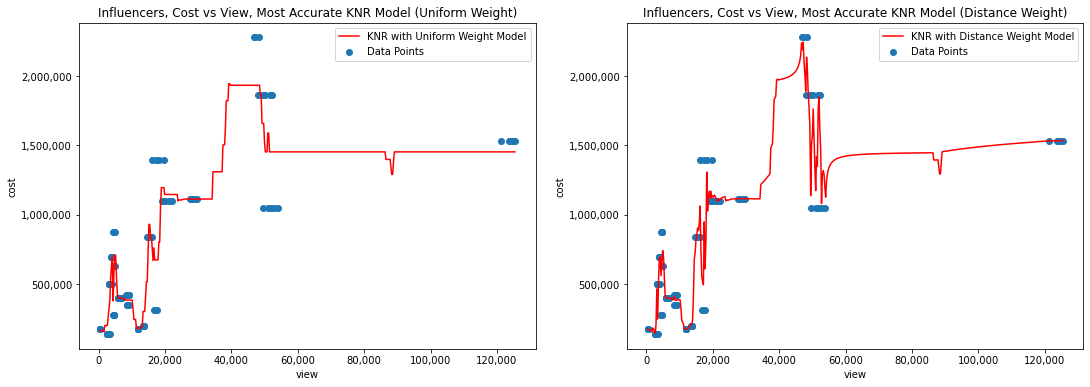

In [22]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(influencer_dummy['view'], influencer_dummy['cost'], label='Data Points')
ax2.scatter(influencer_dummy['view'], influencer_dummy['cost'], label='Data Points')
X_plot = np.linspace(influencer_dummy['view'].min(), influencer_dummy['view'].max(), 500).reshape(-1, 1)
y_plot_uniform = knr_uniform.fit(influencer_x[:, 1].reshape(-1, 1), influencer_y).predict(X_plot)
y_plot_distance = knr_distance.fit(influencer_x[:, 1].reshape(-1, 1), influencer_y).predict(X_plot)
ax1.plot(X_plot, y_plot_uniform, '-r', label='KNR with Uniform Weight Model')
ax2.plot(X_plot, y_plot_distance, '-r', label='KNR with Distance Weight Model')
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.set_title(f'Influencers, Cost vs View, Most Accurate KNR Model (Uniform Weight)')
ax1.set_xlabel('view')
ax1.set_ylabel('cost')
ax1.legend()
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_title(f'Influencers, Cost vs View, Most Accurate KNR Model (Distance Weight)')
ax2.set_xlabel('view')
ax2.set_ylabel('cost')
ax2.legend()
plt.show()

#### Leaders Posts

In [23]:
temp_lst = []
neighbors = np.arange(2, 10)
for i in tqdm_notebook(range(2, 9)):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(leaders_post_x):
        X_train, X_test = leaders_post_x[train_index], leaders_post_x[test_index]
        y_train, y_test = leaders_post_y[train_index], leaders_post_y[test_index]
        for n in np.arange(2, 5):
            for w in weights:
                knr = KNeighborsRegressor(n_neighbors = n, weights = w)
                knr.fit(X_train, y_train)
                temp_lst2 = []
                temp_lst2.append(i)
                temp_lst2.append(n)
                temp_lst2.append(w)
                temp_lst2.append(knr.score(X_train, y_train))
                temp_lst2.append(knr.score(X_test, y_test))
                temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst, columns=['k', '# of Neighbors', 'Weights', 'KNR Train Score', 'KNR Test Score'])

temp_lst = []
for k in range(2, 9):
    for n_ in np.arange(2, 5):
        for w_ in weights:
            temp_lst2 = []
            temp_lst2.append(k)
            temp_lst2.append(n_)
            temp_lst2.append(w_)
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['# of Neighbors'] == n_) & 
                                                      (temp_df['Weights'] == w_)]['KNR Train Score']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['# of Neighbors'] == n_) & 
                                                      (temp_df['Weights'] == w_)]['KNR Test Score']), decimals=4))
            temp_lst.append(temp_lst2)

nn_reg_eval_df = pd.DataFrame(temp_lst, columns=['k', '# of Neighbors', 'Weights', 'KNR Train Score', 'KNR Test Score'])
nn_reg_eval_df

,k,# of Neighbors,Weights,KNR Train Score,KNR Test Score
0,2,2,uniform,0.65,0.43
1,2,2,distance,1.00,0.49
2,2,3,uniform,0.48,0.34
3,2,3,distance,1.00,0.51
4,2,4,uniform,0.15,-0.03
5,2,4,distance,1.00,0.47
6,3,2,uniform,0.73,0.29
7,3,2,distance,1.00,0.32
8,3,3,uniform,0.48,0.02
9,3,3,distance,1.00,0.25


In [24]:
nn_reg_eval_df.nlargest(3, 'KNR Test Score')

,k,# of Neighbors,Weights,KNR Train Score,KNR Test Score
37,8,2,distance,1.00,0.97
39,8,3,distance,1.00,0.92
41,8,4,distance,1.00,0.85


In [25]:
nn_reg_eval_df.nsmallest(3, 'KNR Test Score')

,k,# of Neighbors,Weights,KNR Train Score,KNR Test Score
13,4,2,distance,1.00,-158.40
15,4,3,distance,1.00,-142.79
17,4,4,distance,1.00,-120.69


it seems like that the k-nearest regression is best perfroming algorithm for this dataset since it got 97% accuracy on test set.

In [26]:
knr_uniform = KNeighborsRegressor(n_neighbors=2, weights='uniform')
knr_distance = KNeighborsRegressor(n_neighbors=2, weights='distance')
knr_uniform = knr_uniform.fit(leaders_post_x, leaders_post_y)
knr_distance = knr_distance.fit(leaders_post_x, leaders_post_y)

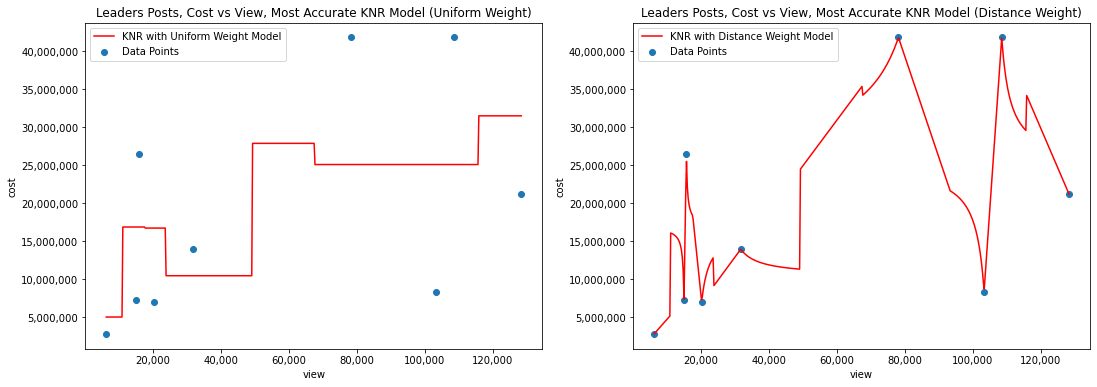

In [27]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(leaders_post_dummy['view'], leaders_post_dummy['cost'], label='Data Points')
ax2.scatter(leaders_post_dummy['view'], leaders_post_dummy['cost'], label='Data Points')
X_plot = np.linspace(leaders_post_dummy['view'].min(), leaders_post_dummy['view'].max(), 500).reshape(-1, 1)
y_plot_uniform = knr_uniform.fit(leaders_post_x[:, 1].reshape(-1, 1), leaders_post_y).predict(X_plot)
y_plot_distance = knr_distance.fit(leaders_post_x[:, 1].reshape(-1, 1), leaders_post_y).predict(X_plot)
ax1.plot(X_plot, y_plot_uniform, '-r', label='KNR with Uniform Weight Model')
ax2.plot(X_plot, y_plot_distance, '-r', label='KNR with Distance Weight Model')
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.set_title(f'Leaders Posts, Cost vs View, Most Accurate KNR Model (Uniform Weight)')
ax1.set_xlabel('view')
ax1.set_ylabel('cost')
ax1.legend()
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_title(f'Leaders Posts, Cost vs View, Most Accurate KNR Model (Distance Weight)')
ax2.set_xlabel('view')
ax2.set_ylabel('cost')
ax2.legend()
plt.show()

### Decision Tree Regressor
#### Advertising Posts

In [28]:
from sklearn.tree import DecisionTreeRegressor

In [29]:
criterion = ['mse', 'friedman_mse', 'mae']

In [30]:
temp_lst = []
for i in tqdm_notebook(range(2, 9)):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(ad_post_x):
        X_train, X_test = ad_post_x[train_index], ad_post_x[test_index]
        y_train, y_test = ad_post_y[train_index], ad_post_y[test_index]
        for c in criterion:
            dtr = DecisionTreeRegressor(criterion = c, max_features = 'auto')
            dtr.fit(X_train, y_train)
            temp_lst2 = []
            temp_lst2.append(i)
            temp_lst2.append(c)
            temp_lst2.append(dtr.score(X_train, y_train))
            temp_lst2.append(dtr.score(X_test, y_test))
            temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst, columns=['k', 'Criterion', 'DTR Train Score', 'DTR Test Score'])

temp_lst = []
for k in range(2, 9):
    for c_ in criterion:
        temp_lst2 = []
        temp_lst2.append(k)
        temp_lst2.append(c_)
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['Criterion'] == c_)]['DTR Train Score']), decimals=4))
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['Criterion'] == c_)]['DTR Test Score']), decimals=4))
        temp_lst.append(temp_lst2)

dt_reg_eval_df = pd.DataFrame(temp_lst, columns=['k', 'Criterion', 'DTR Train Score', 'DTR Test Score'])
dt_reg_eval_df

,k,Criterion,DTR Train Score,DTR Test Score
0,2,mse,1.00,0.45
1,2,friedman_mse,1.00,0.40
2,2,mae,1.00,0.50
3,3,mse,1.00,0.46
4,3,friedman_mse,1.00,0.61
5,3,mae,1.00,0.51
6,4,mse,1.00,0.69
7,4,friedman_mse,1.00,0.66
8,4,mae,1.00,0.74
9,5,mse,1.00,0.53


In [31]:
dt_reg_eval_df.nlargest(3, 'DTR Test Score')

,k,Criterion,DTR Train Score,DTR Test Score
8,4,mae,1.00,0.74
11,5,mae,1.00,0.72
15,7,mse,1.00,0.70


In [32]:
dtr = DecisionTreeRegressor(max_features='auto', criterion='mse')

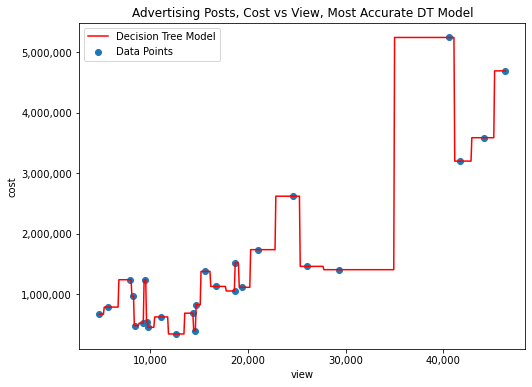

In [33]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

ax.scatter(ad_post_dummy['view'], ad_post_dummy['cost'], label='Data Points')
X_plot = np.linspace(ad_post_dummy['view'].min(), ad_post_dummy['view'].max(), 500).reshape(-1, 1)
y_plot = dtr.fit(ad_post_x[:, 1].reshape(-1, 1), ad_post_y).predict(X_plot)
ax.plot(X_plot, y_plot, '-r', label='Decision Tree Model')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title(f'Advertising Posts, Cost vs View, Most Accurate DT Model')
ax.set_xlabel('view')
ax.set_ylabel('cost')
ax.legend()
plt.show()

#### Advertising Story

In [34]:
temp_lst = []
for i in tqdm_notebook(range(2, 9)):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(ad_story_x):
        X_train, X_test = ad_story_x[train_index], ad_story_x[test_index]
        y_train, y_test = ad_story_y[train_index], ad_story_y[test_index]
        for c in criterion:
            dtr = DecisionTreeRegressor(criterion = c, max_features = 'auto')
            dtr.fit(X_train, y_train)
            temp_lst2 = []
            temp_lst2.append(i)
            temp_lst2.append(c)
            temp_lst2.append(dtr.score(X_train, y_train))
            temp_lst2.append(dtr.score(X_test, y_test))
            temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst, columns=['k', 'Criterion', 'DTR Train Score', 'DTR Test Score'])

temp_lst = []
for k in range(2, 9):
    for c_ in criterion:
        temp_lst2 = []
        temp_lst2.append(k)
        temp_lst2.append(c_)
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['Criterion'] == c_)]['DTR Train Score']), decimals=4))
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['Criterion'] == c_)]['DTR Test Score']), decimals=4))
        temp_lst.append(temp_lst2)

dt_reg_eval_df = pd.DataFrame(temp_lst, columns=['k', 'Criterion', 'DTR Train Score', 'DTR Test Score'])
dt_reg_eval_df

,k,Criterion,DTR Train Score,DTR Test Score
0,2,mse,1.00,0.67
1,2,friedman_mse,1.00,0.42
2,2,mae,1.00,0.69
3,3,mse,1.00,0.79
4,3,friedman_mse,1.00,0.78
5,3,mae,1.00,0.64
6,4,mse,1.00,0.70
7,4,friedman_mse,1.00,0.73
8,4,mae,1.00,0.75
9,5,mse,1.00,0.28


In [35]:
dt_reg_eval_df.nlargest(3, 'DTR Test Score')

,k,Criterion,DTR Train Score,DTR Test Score
3,3,mse,1.00,0.79
4,3,friedman_mse,1.00,0.78
8,4,mae,1.00,0.75


In [36]:
dtr = DecisionTreeRegressor(max_features='auto', criterion='mae')

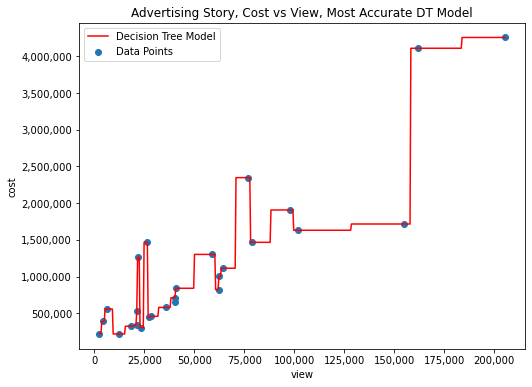

In [37]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

ax.scatter(ad_story_dummy['view'], ad_story_dummy['cost'], label='Data Points')
X_plot = np.linspace(ad_story_dummy['view'].min(), ad_story_dummy['view'].max(), 500).reshape(-1, 1)
y_plot = dtr.fit(ad_story_x[:, 0].reshape(-1, 1), ad_story_y).predict(X_plot)
ax.plot(X_plot, y_plot, '-r', label='Decision Tree Model')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title(f'Advertising Story, Cost vs View, Most Accurate DT Model')
ax.set_xlabel('view')
ax.set_ylabel('cost')
ax.legend()
plt.show()

#### Influencers

In [38]:
temp_lst = []
for i in tqdm_notebook(range(2, 9)):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(influencer_x):
        X_train, X_test = influencer_x[train_index], influencer_x[test_index]
        y_train, y_test = influencer_y[train_index], influencer_y[test_index]
        for c in criterion:
            dtr = DecisionTreeRegressor(criterion = c, max_features = 'auto')
            dtr.fit(X_train, y_train)
            temp_lst2 = []
            temp_lst2.append(i)
            temp_lst2.append(c)
            temp_lst2.append(dtr.score(X_train, y_train))
            temp_lst2.append(dtr.score(X_test, y_test))
            temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst, columns=['k', 'Criterion', 'DTR Train Score', 'DTR Test Score'])

temp_lst = []
for k in range(2, 9):
    for c_ in criterion:
        temp_lst2 = []
        temp_lst2.append(k)
        temp_lst2.append(c_)
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['Criterion'] == c_)]['DTR Train Score']), decimals=4))
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['Criterion'] == c_)]['DTR Test Score']), decimals=4))
        temp_lst.append(temp_lst2)

dt_reg_eval_df = pd.DataFrame(temp_lst, columns=['k', 'Criterion', 'DTR Train Score', 'DTR Test Score'])
dt_reg_eval_df

,k,Criterion,DTR Train Score,DTR Test Score
0,2,mse,1.00,0.28
1,2,friedman_mse,1.00,-0.11
2,2,mae,1.00,-0.64
3,3,mse,1.00,-0.61
4,3,friedman_mse,1.00,-0.60
5,3,mae,1.00,-0.52
6,4,mse,1.00,0.02
7,4,friedman_mse,1.00,-0.02
8,4,mae,1.00,-0.42
9,5,mse,1.00,-1.28


In [39]:
dt_reg_eval_df.nlargest(3, 'DTR Test Score')

,k,Criterion,DTR Train Score,DTR Test Score
0,2,mse,1.00,0.28
14,6,mae,1.00,0.21
6,4,mse,1.00,0.02


as you can see in the table above, decision tree regressoris not a good fit for influencers dataset.

#### Leaders Post

In [40]:
temp_lst = []
for i in tqdm_notebook(range(2, 9)):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(leaders_post_x):
        X_train, X_test = leaders_post_x[train_index], leaders_post_x[test_index]
        y_train, y_test = leaders_post_y[train_index], leaders_post_y[test_index]
        for c in criterion:
            dtr = DecisionTreeRegressor(criterion = c, max_features = 'auto')
            dtr.fit(X_train, y_train)
            temp_lst2 = []
            temp_lst2.append(i)
            temp_lst2.append(c)
            temp_lst2.append(dtr.score(X_train, y_train))
            temp_lst2.append(dtr.score(X_test, y_test))
            temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst, columns=['k', 'Criterion', 'DTR Train Score', 'DTR Test Score'])

temp_lst = []
for k in range(2, 9):
    for c_ in criterion:
        temp_lst2 = []
        temp_lst2.append(k)
        temp_lst2.append(c_)
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['Criterion'] == c_)]['DTR Train Score']), decimals=4))
        temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['Criterion'] == c_)]['DTR Test Score']), decimals=4))
        temp_lst.append(temp_lst2)

dt_reg_eval_df = pd.DataFrame(temp_lst, columns=['k', 'Criterion', 'DTR Train Score', 'DTR Test Score'])
dt_reg_eval_df

,k,Criterion,DTR Train Score,DTR Test Score
0,2,mse,1.00,-0.15
1,2,friedman_mse,1.00,-0.60
2,2,mae,1.00,-0.34
3,3,mse,1.00,-0.12
4,3,friedman_mse,1.00,-0.39
5,3,mae,1.00,-0.45
6,4,mse,1.00,-162.24
7,4,friedman_mse,1.00,-162.30
8,4,mae,1.00,-162.28
9,5,mse,1.00,-4.64


In [41]:
dt_reg_eval_df.nlargest(3, 'DTR Test Score')

,k,Criterion,DTR Train Score,DTR Test Score
19,8,friedman_mse,1.00,1.00
18,8,mse,1.00,0.97
20,8,mae,1.00,0.97


as you can see in the tables above, decision tree algorithm managed to achieve the perfect score on this dataset.

In [42]:
dtr = DecisionTreeRegressor(max_features='auto', criterion='friedman_mse')

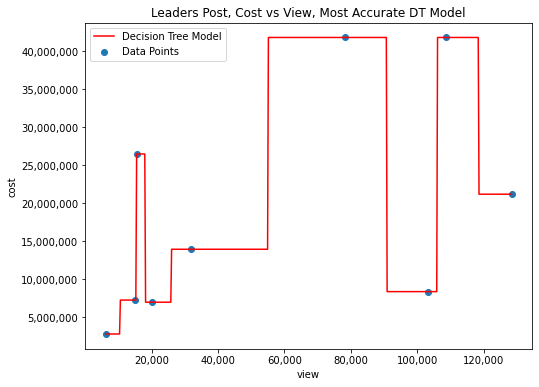

In [43]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

ax.scatter(leaders_post_dummy['view'], leaders_post_dummy['cost'], label='Data Points')
X_plot = np.linspace(leaders_post_dummy['view'].min(), leaders_post_dummy['view'].max(), 500).reshape(-1, 1)
y_plot = dtr.fit(leaders_post_x[:, 1].reshape(-1, 1), leaders_post_y).predict(X_plot)
ax.plot(X_plot, y_plot, '-r', label='Decision Tree Model')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title(f'Leaders Post, Cost vs View, Most Accurate DT Model')
ax.set_xlabel('view')
ax.set_ylabel('cost')
ax.legend()
plt.show()

### Random Forrest Regression
#### Advertising Posts

In [44]:
from sklearn.ensemble import RandomForestRegressor

In [45]:
criterion = ['mse', 'mae']
n_estimators = np.arange(10, 210, 10, dtype='int16')

In [46]:
temp_lst = []
for i in tqdm(range(2, 9)):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(ad_post_x):
        X_train, X_test = ad_post_x[train_index], ad_post_x[test_index]
        y_train, y_test = ad_post_y[train_index], ad_post_y[test_index]
        for c in criterion:
            for n in n_estimators:
                rfr = RandomForestRegressor(criterion = c, n_estimators = n)
                rfr.fit(X_train, y_train)
                temp_lst2 = []
                temp_lst2.append(i)
                temp_lst2.append(c)
                temp_lst2.append(n)
                temp_lst2.append(rfr.score(X_train, y_train))
                temp_lst2.append(rfr.score(X_test, y_test))
                temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst, columns=['k', 'Criterion', '# of Trees', 'RFR Train Score', 'RFR Test Score'])

temp_lst = []
for k in range(2, 9):
    for c_ in criterion:
        for n_ in n_estimators:
            temp_lst2 = []
            temp_lst2.append(k)
            temp_lst2.append(c_)
            temp_lst2.append(n_)
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['Criterion'] == c_) &
                                                      (temp_df['# of Trees'] == n_)]['RFR Train Score']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['Criterion'] == c_) &
                                                      (temp_df['# of Trees'] == n_)]['RFR Test Score']), decimals=4))
            temp_lst.append(temp_lst2)

rfr_reg_eval_df = pd.DataFrame(temp_lst, columns=['k', 'Criterion', '# of Trees in Forest', 'RFR Train Score', 'RFR Test Score'])
rfr_reg_eval_df

100%|██████████| 7/7 [03:28<00:00, 29.74s/it]


,k,Criterion,# of Trees in Forest,RFR Train Score,RFR Test Score
0,2,mse,10,0.96,0.77
1,2,mse,20,0.93,0.73
2,2,mse,30,0.91,0.74
3,2,mse,40,0.89,0.69
4,2,mse,50,0.92,0.76
...,...,...,...,...,...
275,8,mae,160,0.98,0.54
276,8,mae,170,0.98,0.60
277,8,mae,180,0.98,0.58
278,8,mae,190,0.98,0.63


In [47]:
rfr_reg_eval_df.nlargest(3, 'RFR Test Score')

,k,Criterion,# of Trees in Forest,RFR Train Score,RFR Test Score
86,4,mse,70,0.97,0.83
63,3,mae,40,0.97,0.82
65,3,mae,60,0.97,0.82


#### Advertising Stories

In [48]:
temp_lst = []
for i in tqdm(range(2, 9)):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(ad_story_x):
        X_train, X_test = ad_story_x[train_index], ad_story_x[test_index]
        y_train, y_test = ad_story_y[train_index], ad_story_y[test_index]
        for c in criterion:
            for n in n_estimators:
                rfr = RandomForestRegressor(criterion = c, n_estimators = n)
                rfr.fit(X_train, y_train)
                temp_lst2 = []
                temp_lst2.append(i)
                temp_lst2.append(c)
                temp_lst2.append(n)
                temp_lst2.append(rfr.score(X_train, y_train))
                temp_lst2.append(rfr.score(X_test, y_test))
                temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst, columns=['k', 'Criterion', '# of Trees', 'RFR Train Score', 'RFR Test Score'])

temp_lst = []
for k in range(2, 9):
    for c_ in criterion:
        for n_ in n_estimators:
            temp_lst2 = []
            temp_lst2.append(k)
            temp_lst2.append(c_)
            temp_lst2.append(n_)
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['Criterion'] == c_) &
                                                      (temp_df['# of Trees'] == n_)]['RFR Train Score']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['Criterion'] == c_) &
                                                      (temp_df['# of Trees'] == n_)]['RFR Test Score']), decimals=4))
            temp_lst.append(temp_lst2)

rfr_reg_eval_df = pd.DataFrame(temp_lst, columns=['k', 'Criterion', '# of Trees in Forest', 'RFR Train Score', 'RFR Test Score'])
rfr_reg_eval_df

100%|██████████| 7/7 [03:28<00:00, 29.76s/it]


,k,Criterion,# of Trees in Forest,RFR Train Score,RFR Test Score
0,2,mse,10,0.96,0.86
1,2,mse,20,0.96,0.79
2,2,mse,30,0.94,0.85
3,2,mse,40,0.94,0.82
4,2,mse,50,0.93,0.84
...,...,...,...,...,...
275,8,mae,160,0.97,0.51
276,8,mae,170,0.97,0.49
277,8,mae,180,0.97,0.48
278,8,mae,190,0.97,0.50


In [49]:
rfr_reg_eval_df.nlargest(3, 'RFR Test Score')

,k,Criterion,# of Trees in Forest,RFR Train Score,RFR Test Score
9,2,mse,100,0.95,0.88
29,2,mae,100,0.94,0.87
24,2,mae,50,0.94,0.87


#### Influencers

In [50]:
temp_lst = []
for i in tqdm(range(2, 9)):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(influencer_x):
        X_train, X_test = influencer_x[train_index], influencer_x[test_index]
        y_train, y_test = influencer_y[train_index], influencer_y[test_index]
        for c in criterion:
            for n in n_estimators:
                rfr = RandomForestRegressor(criterion = c, n_estimators = n)
                rfr.fit(X_train, y_train)
                temp_lst2 = []
                temp_lst2.append(i)
                temp_lst2.append(c)
                temp_lst2.append(n)
                temp_lst2.append(rfr.score(X_train, y_train))
                temp_lst2.append(rfr.score(X_test, y_test))
                temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst, columns=['k', 'Criterion', '# of Trees', 'RFR Train Score', 'RFR Test Score'])

temp_lst = []
for k in range(2, 9):
    for c_ in criterion:
        for n_ in n_estimators:
            temp_lst2 = []
            temp_lst2.append(k)
            temp_lst2.append(c_)
            temp_lst2.append(n_)
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['Criterion'] == c_) &
                                                      (temp_df['# of Trees'] == n_)]['RFR Train Score']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['Criterion'] == c_) &
                                                      (temp_df['# of Trees'] == n_)]['RFR Test Score']), decimals=4))
            temp_lst.append(temp_lst2)

rfr_reg_eval_df = pd.DataFrame(temp_lst, columns=['k', 'Criterion', '# of Trees in Forest', 'RFR Train Score', 'RFR Test Score'])
rfr_reg_eval_df

100%|██████████| 7/7 [04:02<00:00, 34.58s/it]


,k,Criterion,# of Trees in Forest,RFR Train Score,RFR Test Score
0,2,mse,10,0.99,-0.00
1,2,mse,20,1.00,-0.09
2,2,mse,30,1.00,-0.02
3,2,mse,40,1.00,-0.07
4,2,mse,50,1.00,-0.02
...,...,...,...,...,...
275,8,mae,160,1.00,-0.11
276,8,mae,170,1.00,-0.07
277,8,mae,180,1.00,-0.17
278,8,mae,190,1.00,-0.17


In [51]:
rfr_reg_eval_df.nlargest(3, 'RFR Test Score')

,k,Criterion,# of Trees in Forest,RFR Train Score,RFR Test Score
85,4,mse,60,0.99,0.27
84,4,mse,50,1.00,0.26
89,4,mse,100,1.00,0.23


as it was obvious, since the tree-based algorithms didn't perform well on influencer dataset, random forest won't change this fact.

#### Leaders Post

In [52]:
temp_lst = []
for i in tqdm(range(2, 9)):
    kf = KFold(n_splits = i)
    for train_index, test_index in kf.split(leaders_post_x):
        X_train, X_test = leaders_post_x[train_index], leaders_post_x[test_index]
        y_train, y_test = leaders_post_y[train_index], leaders_post_y[test_index]
        for c in criterion:
            for n in n_estimators:
                rfr = RandomForestRegressor(criterion = c, n_estimators = n)
                rfr.fit(X_train, y_train)
                temp_lst2 = []
                temp_lst2.append(i)
                temp_lst2.append(c)
                temp_lst2.append(n)
                temp_lst2.append(rfr.score(X_train, y_train))
                temp_lst2.append(rfr.score(X_test, y_test))
                temp_lst.append(temp_lst2)

temp_df = pd.DataFrame(temp_lst, columns=['k', 'Criterion', '# of Trees', 'RFR Train Score', 'RFR Test Score'])

temp_lst = []
for k in range(2, 9):
    for c_ in criterion:
        for n_ in n_estimators:
            temp_lst2 = []
            temp_lst2.append(k)
            temp_lst2.append(c_)
            temp_lst2.append(n_)
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['Criterion'] == c_) &
                                                      (temp_df['# of Trees'] == n_)]['RFR Train Score']), decimals=4))
            temp_lst2.append(np.round(np.mean(temp_df[(temp_df['k'] == k) & (temp_df['Criterion'] == c_) &
                                                      (temp_df['# of Trees'] == n_)]['RFR Test Score']), decimals=4))
            temp_lst.append(temp_lst2)

rfr_reg_eval_df = pd.DataFrame(temp_lst, columns=['k', 'Criterion', '# of Trees in Forest', 'RFR Train Score', 'RFR Test Score'])
rfr_reg_eval_df

100%|██████████| 7/7 [03:04<00:00, 26.41s/it]


,k,Criterion,# of Trees in Forest,RFR Train Score,RFR Test Score
0,2,mse,10,0.89,0.24
1,2,mse,20,0.72,0.10
2,2,mse,30,0.80,0.12
3,2,mse,40,0.78,0.21
4,2,mse,50,0.81,0.16
...,...,...,...,...,...
275,8,mae,160,0.88,0.74
276,8,mae,170,0.88,0.78
277,8,mae,180,0.87,0.84
278,8,mae,190,0.88,0.81


In [53]:
rfr_reg_eval_df.nlargest(3, 'RFR Test Score')

,k,Criterion,# of Trees in Forest,RFR Train Score,RFR Test Score
261,8,mae,20,0.84,0.88
268,8,mae,90,0.87,0.84
253,8,mse,140,0.87,0.84


----

## Regression Algorithms Summary

in the table below you can see the performance summary of most accurate regression model which we tested and discussed in this notebook and previous one.

In [54]:
data = {
    'Regression Algorithms': ['Linear', 'Polynomial', 'Ridge', 'Lasso', 'Support Vector Machine', 'k-Nearest', 'Decision Tree', 'Random Forest'],
    'Advertising Post - Train Score': [0.93, 0.86, 0.93, 0.93, 0.86, 0.88, 1, 0.97],
    'Advertising Post - Test Score': [0.77, 0.70, 0.77, 0.80, 0.74, 0.44, 0.74, 0.83],
    'Advertising Story - Train Score': [1, 0.81, 1, 1, 0.97, 1, 1, 0.95],
    'Advertising Story - Test Score': [0.96, 0.71, 0.96, 0.96, 0.94, 0.44, 0.79, 0.88],
    'Influencers - Train Score': [0.22, '-', 0.86, 0.86, 0.72, 1, 1, 0.99],
    'Influencers - Test Score': [0.25, '-', 0.43, 0.40, 0.65, 0.65, 0.28, 0.27],
    'Leaders Post - Train Score': ['-', 0.41, '-', '-', 0.80, 1, 1, 0.84],
    'Leaders Post - Test Score': ['-', 0.40, '-', '-', 0.16, 0.97, 1, 0.88]}
score_df = pd.DataFrame(data=data)
score_df

,Regression Algorithms,Advertising Post - Train Score,Advertising Post - Test Score,Advertising Story - Train Score,Advertising Story - Test Score,Influencers - Train Score,Influencers - Test Score,Leaders Post - Train Score,Leaders Post - Test Score
0,Linear,0.93,0.77,1.00,0.96,0.22,0.25,-,-
1,Polynomial,0.86,0.70,0.81,0.71,-,-,0.41,0.40
2,Ridge,0.93,0.77,1.00,0.96,0.86,0.43,-,-
3,Lasso,0.93,0.80,1.00,0.96,0.86,0.40,-,-
4,Support Vector Machine,0.86,0.74,0.97,0.94,0.72,0.65,0.80,0.16
5,k-Nearest,0.88,0.44,1.00,0.44,1,0.65,1,0.97
6,Decision Tree,1.00,0.74,1.00,0.79,1,0.28,1,1
7,Random Forest,0.97,0.83,0.95,0.88,0.99,0.27,0.84,0.88


lowest accuracy for datasets is for influencers dataset, in more technical wording, the variance of these models are higher than normal and thus, in orderto fix that, we are in need of more data. without additional data this accuracy couldn't be increased significantly. on other data sets we managed to achieve high score and accuracy.

----
# Notebook by Ramin F. - @simplyramin